# 05: Neutral Atom Simulator (Worked Solution)

This is one possible way to implement a simple circuit simulator for an array of neutral atoms. It is not the only way or even necessarily "the best way".

The implementation is intended to be simple and readable, while still implementing a set of universal gates.

## Imports

In [1]:
import qutip
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Helper functions

The `computational_basis_blochs` function makes plotting the outcomes of circuits more convenient. It is not part of the simulator, but it is very useful. It keeps the notebook cells readable, and allows one to focus on the task at hand, rather than worrying about the details of sub-tasks like plotting.

Note that one cannot represent the complete state of N-qubits or N-qutrits on N Bloch spheres -- separating the state loses information about entanglement between them. Also note that the fully mixed state for one qubit (i.e. a 50/50 mixture of the |0> and |1> states) is rendered at the origin of the Bloch sphere.

In [3]:
def computational_basis_blochs(states, colors="r", view=(60, 30)):
    """ Render each qutrit separately on a Bloch sphere, showing only the computational basis states,
        i.e. the states |0> and |1>, tracing out the Rydberg interaction state |2>.
        
        Parameters
        ----------
        states : list of Qobj, or a single Qobj
            The N-qutrit states to display. Each qutrit is plotted separately on the Bloch sphere
            by first tracing out the others and then dropping the parts of the density matrix that
            depend on the |2> state.
            
        colors : list or str of colors, default "r"
            Specifies the color to use when displaying each of the N-qutrits. If the number of qutrits
            is greater than the number of colors, the function cycles through the list of colors. The
            default, "r", shows all qutrits in red.
            
        view : tuple of two floats, default (60, 30)
            The angle to view the bloch sphere from.
    """
    b = qutip.Bloch()
    b.view = list(view)
    b.vector_color = []
    if isinstance(states, qutip.Qobj):
        states = [states]
    if states:
        for i in range(len(states[0].dims[0])):
            c = colors[i % len(colors)]
            b.vector_color.extend([c] * len(states))
            for s, alpha in zip(states, np.linspace(0.5, 1.0, len(states))):
                rho_qutrit_i = qutip.ptrace(s, i)
                rho_qubit_i = qutip.Qobj(rho_qutrit_i.full()[:2, :2], dims=[[2], [2]])
                b.add_states(rho_qubit_i, alpha=alpha)
    b.show()

## Implementation

We implement the simulator as a single class. This keeps the implementation all neatly in one place.

Here is an overview of the methods of the class to help in understanding it:

- `__init__`:

  This sets up various constants, such as the qutrit basis elements, the qubit Pauli operators, the Rydberg
  interaction Hamiltonian, the solver options. It also sets up an empty list of pulses and initializes the
  end time of the last pulse, `t`, to `0`.
  
- `state`:

  A convenience function that returns a system state based on a string describing the state of each qubit. For
  example, `circuit.state("01")` returns `|0> ⊗ |1>`.
  
- `_place_op`:

  Expands an operator on a single atom to an operator on the full state of all atoms, but tensoring the
  operation with appropriate copies of the identity. For example, `_place_op(1, op)` returns `I ⊗ op`.
  
- `_add_pulse`:

  Adds a new pulse to the list of pulses, starting at the end of the last pulses, i.e. `self.t`, and lasting
  for duration `dt`. The list of pulses is added to the constant Hamiltonian when the circuit is run.
  
- `rx`, `ry`, `rz`, `h`:

  Implementations of the single qubit gates. Each of these adds a list of pulses that act on the specified
  qubit / atom.
  
- `cz`, `cnot`:

  Implementations of the two qubit gates. These add pulses that act on each of the two qubits, but also
  rely on the Rydberg interaction defined by the constant part of the Hamiltonian for the blockade interaction
  between the two qubits. Note that if the atoms are too far apart, there will be no Rydberg interaction and
  these two qubit gates will not function as expected!
  
- `run`:

  Run the circut and return the results from the QuTiP solver. By default it uses a `tlist` of `range(0, t, t * 20)`
  where `t` is the end of the last pulse, but one may specify a custom `tlist` or adjust the factor of `20`
  by changing `step_rate`.

In [4]:
class NeutralAtomCircuit:
    """ A neutral atom circuit laser pulse simulator.
    
        Parameters
        ----------
        atoms : ndarray or list of (x, y) coordinate tuples
            The 2-D coordinates of each neutral atom. For example, [(1, 0), (0, 1)]. The co-ordinates
            are used to calculate the Rydberg coupling coefficient -- i.e. 1 / R**6 where R is the
            distance between atoms. Distances ~1 give strong coupling. Distances >> 1 give very weak couplings. 
    """

    def __init__(self, atoms):
        self.n = len(atoms)
        self.atoms = np.array(atoms)
        self.pulses = []
        self.t = 0

        # calculate pair-wise distances and couplings:
        # The actual value of C^6 is 862690 * 2 * np.pi (in units of MHz * μm^6) but that makes solving
        # for the dynamics slow, so we use something a bit less:
        self._c6 = 10_000
        self._r_distances = np.linalg.norm(self.atoms[:, None, :] - self.atoms[None, :, :], axis=-1)
        self._r_couplings = np.zeros_like(self._r_distances)
        non_zero = self._r_distances != 0
        self._r_couplings[non_zero] = self._c6 / (self._r_distances[non_zero] ** 6)

        # qutrit basis elements:
        self._a = a = qutip.basis(3, 0)
        self._b = b = qutip.basis(3, 1)
        self._r = r = qutip.basis(3, 2)

        # qutrit pauli matrixes on the computation basis, i.e. ab:
        self._ab_sx = a * b.dag() + b * a.dag()
        self._ab_sy = 1j * a * b.dag() - 1j * b * a.dag()
        self._ab_sz = b * b.dag() - a * a.dag()

        # qutrit sigmax matrix for the |a>, |r> basis:
        self._ar_sx = a * r.dag() + r * a.dag()

        # qutrit rydberg state occupation operator:
        self._rr = r * r.dag()
        
        # construct the time-independent part of the Hamiltonian (i.e. the Rydberg interactions):
        self.H_rydberg = qutip.Qobj(dims=[[3] * self.n, [3] * self.n])
        self.rr = rr = [
            self._place_op(i, self._rr) for i in range(self.n)
        ]
        for i in range(self.n):
            for j in range(i + 1, self.n):
                self.H_rydberg += self._r_couplings[i, j] * rr[i] * rr[j]
                
        # solver options:
        #
        # setting a large nsteps just tells the solver we're happy for solving each timestep to take a long time
        # setting max_step to less than the length of a pulse is extremely important -- if we don't the solver
        #   may skip a pulse entirely.
        max_rydberg_eigenvalue = self.H_rydberg.eigenenergies(sort="high", eigvals=1)[0]
        max_step = 0.1  # fraction of default pulse dt
        self.options = qutip.Options(
            nsteps=max(100 * max_rydberg_eigenvalue * max_step, 10_000),
            max_step=max_step,
        )

    def state(self, s):
        """ Return a ket corresponding to the given string description. For
            example, `.state("01")` returns `|0> ⊗ |1>`. The characters supported are "0", "1", "+" and "-",
            and each represents the expected corresponding basis element.
        """
        states = []
        for c in s:
            if c == "0":
                q = self._a
            elif c == "1":
                q = self._b
            elif c == "+":
                q = self._a + self._b
            elif c == "-":
                q = self._a - self._b
            states.append(q.unit())
        return qutip.tensor(states)


    def _place_op(self, i, op):
        ops = [qutip.qeye(3)] * self.n
        ops[i] = op
        return qutip.tensor(ops)

    def _add_pulse(self, op, dt):
        start = self.t
        end = self.t + dt
        self.t = end
        f = lambda t, args: 1 if start <= t <= end else 0
        self.pulses.append((op, f))

    def rx(self, i, theta, dt=1):
        """ Add a laser pulse that rotates qubit i an angle theta around the X axis. """
        v = 0.5 * theta / dt
        O = v
        op = self._place_op(i, O * self._ab_sx)
        self._add_pulse(op, dt)

    def ry(self, i, theta, dt=1):
        """ Add a laser pulse that rotates qubit i an angle theta around the Y axis. """
        v = 0.5 * theta / dt
        O = v
        op = self._place_op(i, O * self._ab_sy)
        self._add_pulse(op, dt)

    def rz(self, i, theta, dt=1):
        """ Add a laser pulse that rotates qubit i an angle theta around the Z axis. """
        v = 0.5 * theta / dt
        O = v
        op = self._place_op(i, O * self._ab_sz)
        self._add_pulse(op, dt)

    def h(self, i):
        """ Apply a hadamard gate to qubit i. """
        self.rx(i, np.pi)
        self.ry(i, np.pi / 2)

    def cz(self, control, target, dt=1):
        """ Add pulses that perform a controlled-Z phase flip operation on two qubits, assuming the
            atoms are close enough for the Rydberg blockade to prevent both atoms entering the |r> state
            simultaneously.
        """
        v_c = 0.5 * np.pi / dt
        O_c = v_c
        v_t = 0.5 * 2 * np.pi / dt
        O_t = v_t

        op1 = self._place_op(control, O_c * self._ar_sx)  # pi sx rotation from a -> r on control
        op2 = self._place_op(target, O_t * self._ar_sx)  # 2pi sx rotation from a -> r on target
        op3 = self._place_op(control, O_c * self._ar_sx)  # pi sx rotation from a -> r on control

        self._add_pulse(op1, dt)
        self._add_pulse(op2, dt)
        self._add_pulse(op3, dt)

    def cnot(self, control, target):
        """ Apply a CNOT gate to a control and target qubit. """
        # CNOT = (I ⊗ H) CZ (I ⊗ H)
        self.h(target)
        self.cz(control, target)
        self.h(target)

    def run(self, psi, tlist=None, step_rate=20):
        """ Run the circuit. """
        if isinstance(psi, str):
            psi = self.state(psi)
        if tlist is None:
            tlist = np.linspace(0, self.t, int(self.t * step_rate) + 1)
        if self.pulses:
            H = qutip.QobjEvo([self.H_rydberg] + self.pulses)
        else:
            H = qutip.qeye([3] * self.n)
        result = qutip.sesolve(H, psi, tlist=tlist, options=self.options)
        return result

## Example circuits

### Example 1: Pretty sequence of rotations (qubit 0)

Duration of circuit (t): 3
Number of pulses: 3


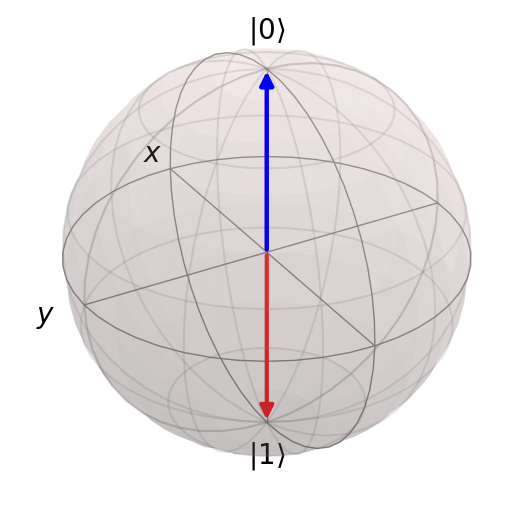

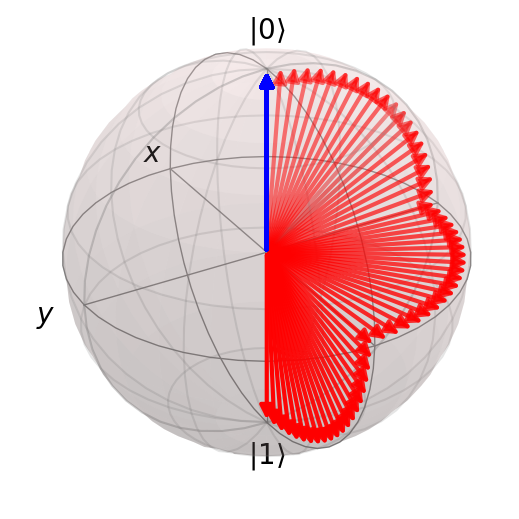

In [5]:
# Example 1: Pretty sequence of rotations (qubit 0)

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

circuit.rx(0, np.pi / 2)
circuit.rz(0, np.pi / 2)
circuit.ry(0, np.pi / 2)

result = circuit.run("00", step_rate=20)

# Show one Bloch sphere with initial and final states and 
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

### Example 2: Pretty sequence of rotations (qubit 1)

Duration of circuit (t): 3
Number of pulses: 3


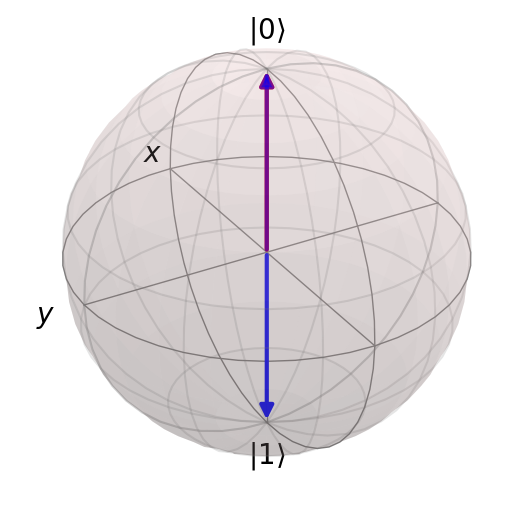

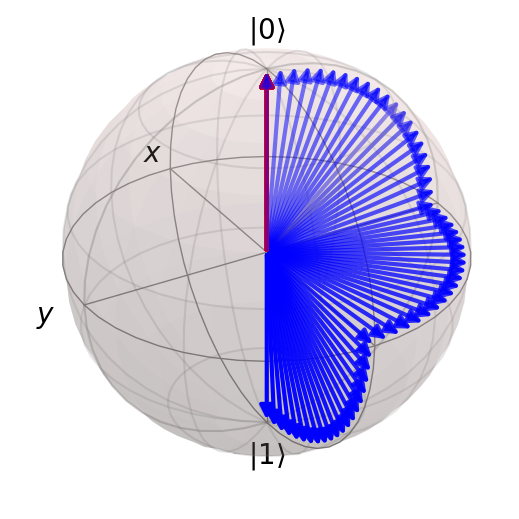

In [6]:
# Example 2: Pretty sequence of rotations (qubit 1)

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

circuit.rx(1, np.pi / 2)
circuit.rz(1, np.pi / 2)
circuit.ry(1, np.pi / 2)

result = circuit.run("00", step_rate=20)

# Show one Bloch sphere with initial and final states and
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

### Example 3: Combine the previous two circuits

Duration of circuit (t): 6
Number of pulses: 6


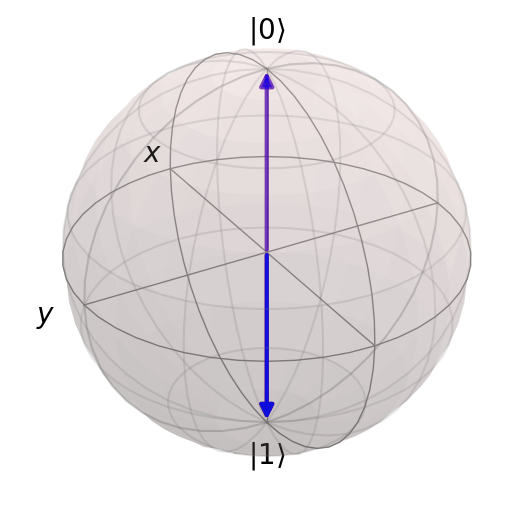

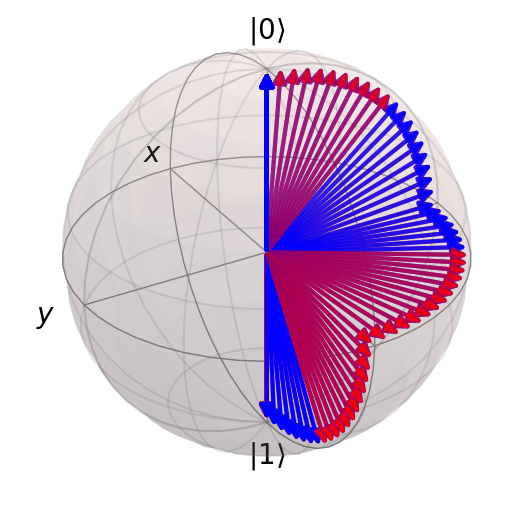

In [7]:
# Example 3: Pretty sequence of rotations (qubit 0 & 1)

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

circuit.rx(0, np.pi / 2)
circuit.rz(0, np.pi / 2)
circuit.ry(0, np.pi / 2)

circuit.rx(1, np.pi / 2)
circuit.rz(1, np.pi / 2)
circuit.ry(1, np.pi / 2)

result = circuit.run("00", step_rate=20)

# Show one Bloch sphere with initial and final states and
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

### Example 4: Hadamard gate (qubit 0)

Duration of circuit (t): 2
Number of pulses: 2


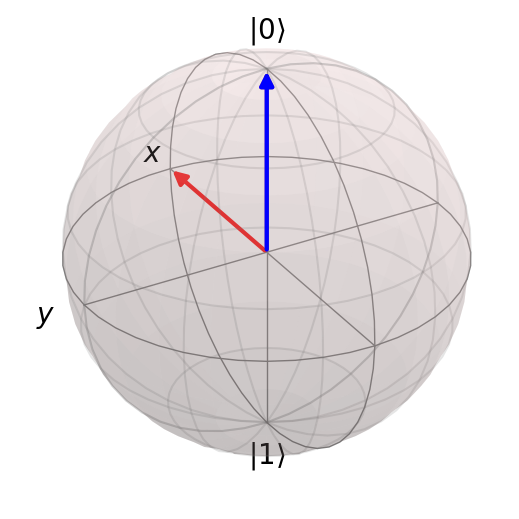

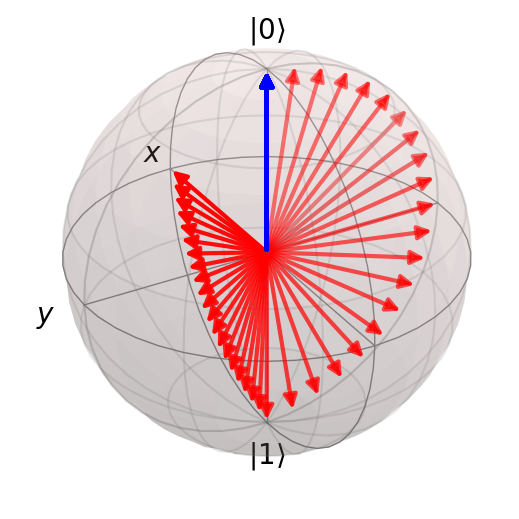

In [8]:
# Example 4: Hadamard gate (qubit 0)

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

# H = Rx(pi) Ry(pi / 2):

circuit.rx(0, np.pi)
circuit.ry(0, np.pi / 2)

result = circuit.run("00", step_rate=20)

# Show one Bloch sphere with initial and final states and
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

### Example 5: CZ gate (control qubit 0, target qubit 1)

Duration of circuit (t): 3
Number of pulses: 3


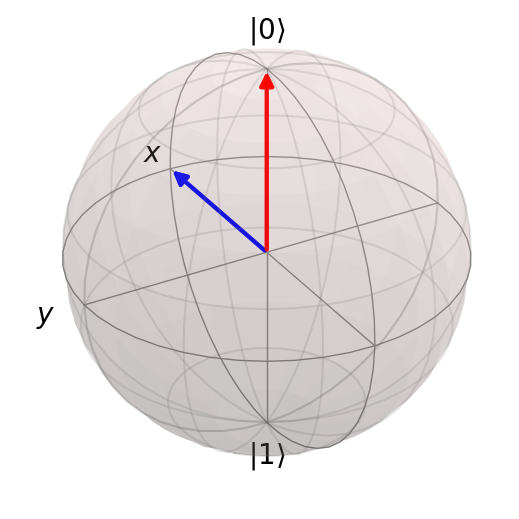

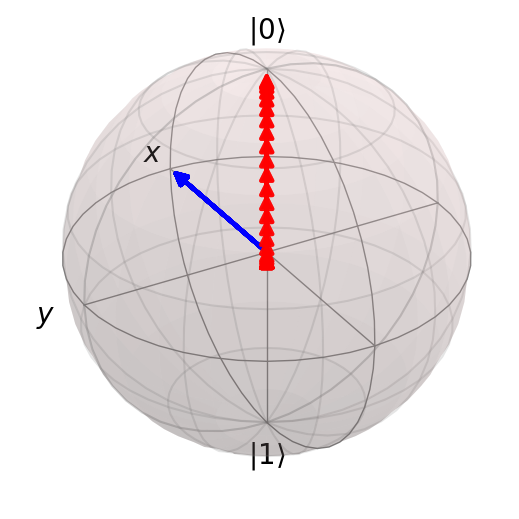

In [9]:
# Example 5: CZ gate (control qubit 0, target qubit 1)

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

circuit.cz(0, 1)

result = circuit.run("0+", step_rate=20)

# Show one Bloch sphere with initial and final states and
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

### Example 6: CNOT gate (control qubit 0, target qubit 1)

Duration of circuit (t): 7
Number of pulses: 7


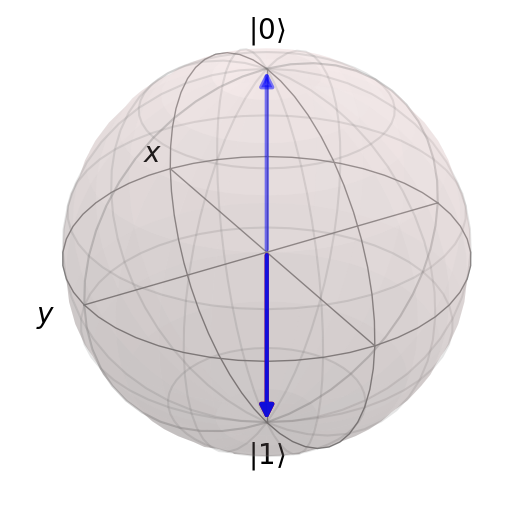

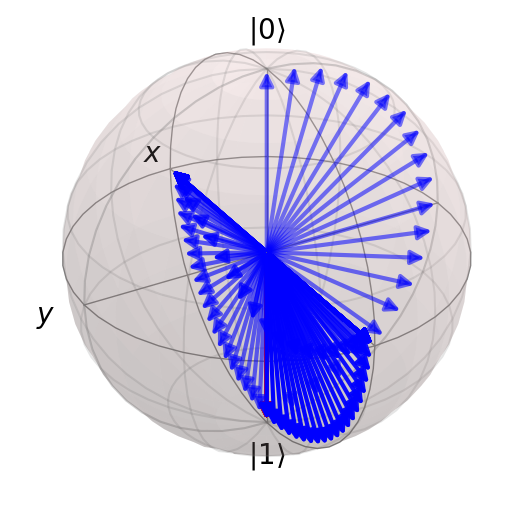

In [10]:
# Example 6: CNOT gate (control qubit 0, target qubit 1)

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

# CNOT = (I ⊗ H) CZ (I ⊗ H):

circuit.h(1)
circuit.cz(0, 1)
circuit.h(1)

result = circuit.run("10", step_rate=20)

# Show one Bloch sphere with initial and final states and
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

### Example 7: Prepare a Bell state

Duration of circuit (t): 9
Number of pulses: 9


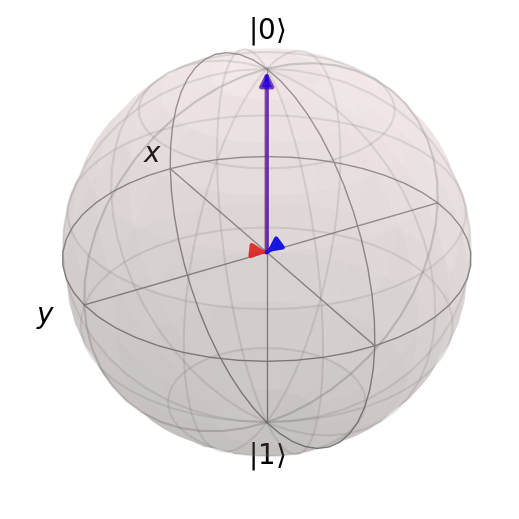

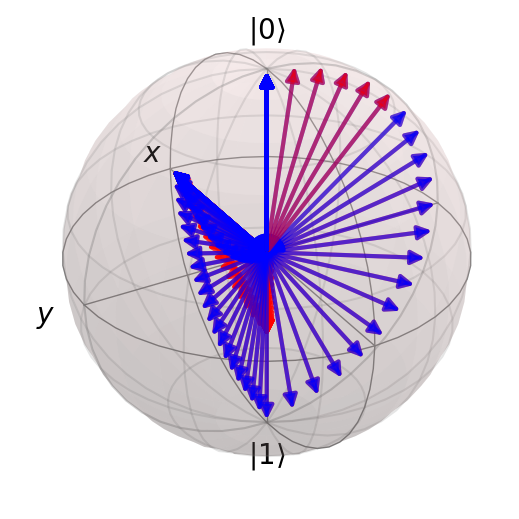

In [11]:
# Example 7: Prepare a Bell state

atoms = [(0.5, 0), (0, 0.5)]
circuit = NeutralAtomCircuit(atoms)

circuit.h(0)
circuit.cnot(0, 1)

result = circuit.run("00", step_rate=20)

# Show one Bloch sphere with initial and final states and
print("Duration of circuit (t):", circuit.t)
print("Number of pulses:", len(circuit.pulses))
computational_basis_blochs([result.states[0], result.states[-1]], "rb")
computational_basis_blochs(result.states, "rb")

The fully entangled state appears as two completely mixed states that are represented by the arrow heads at the centre of the Bloch sphere. Let's check that the final state really is the expected Bell state and not some other state that has the same reduced density matrix probabilities but a different relative phase.

Note: We use `.tidyup(atol=1e-3)` to hide the small but non-zero coefficients. This makes it easier to see the large coefficients, but you should also look at the coefficients without `.tidyup` to see what magnitude they are. The `atol=1e-3` hides all coefficients less than `1e-3`.

To understand what the coefficients on the final state mean, remember that the first coefficient is for the basis state `|aa>`, the second for `|ab>`, the third for `|ar>`, and then remainder for `|ba>`, `|bb>`, `|br>`, `|ra>`, `|rb>` and `|rr>`, in order.

The Bell state is `|aa> + |bb>` so we expect the first and fifth coefficients to be $\frac{1}{\sqrt{2}}$ and the remaining coefficients to be small.

In [12]:
result.states[-1].copy().tidyup(atol=1e-3)

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.-0.70709899j]
 [0.+0.j        ]
 [0.+0.j        ]
 [0.+0.j        ]
 [0.-0.70711456j]
 [0.+0.j        ]
 [0.+0.j        ]
 [0.+0.j        ]
 [0.+0.j        ]]

And here are the reduce density matrices for the two qubits:

In [13]:
result.states[-1].ptrace(0).tidyup(atol=1e-3)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49998898 0.         0.        ]
 [0.         0.50001099 0.        ]
 [0.         0.         0.        ]]

In [14]:
result.states[-1].ptrace(1).tidyup(atol=1e-3)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49998898 0.         0.        ]
 [0.         0.500011   0.        ]
 [0.         0.         0.        ]]

Without the `.tidyup` applied, you can see all the smalller entries in the resulting state. These come from small numerical errors in determining the evolution of the system:

In [15]:
result.states[-1]

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[ 4.63203311e-05-7.07098988e-01j]
 [ 4.56437192e-05+2.00714997e-06j]
 [ 2.03820402e-09-7.25880482e-09j]
 [ 2.02973000e-06+2.09146523e-06j]
 [-2.70627959e-06-7.07114555e-01j]
 [-1.09967062e-13-7.39581611e-08j]
 [ 3.47448797e-07+1.64646247e-11j]
 [-2.19569420e-06+1.16961765e-11j]
 [-1.35419997e-04-6.10699504e-05j]]